# Create new library designer function

Import data.

In [1]:
%load_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
print('load data')
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

load data


In [2]:
building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630.fpb')

# align fingerprints to building blocks
print('align fingerprints')
fingerprints = dg.utils.sort_fingerprints(fingerprints, building_blocks)

# partition building blocks according to functional groups
print('partition building blocks')
templates = dg.utils.get_unique_reactants(reactions)
building_blocks = dg.utils.partition_building_blocks(building_blocks, templates, out_dir=path)

align fingerprints
partition building blocks


Create inputs to the DrugEnv.

In [3]:
import numpy as np
from dgym.envs.library_designer import LibraryDesigner
from dgym.envs.oracle import DGLOracle, RDKitOracle, DockingOracle
from dgym.envs.evaluator import ClassicEvaluator, UtilityFunction

# create library designer
library_designer = LibraryDesigner(
    reactions,
    building_blocks,
    fingerprints
)

Testing the best performing molecule from docking screen.

In [5]:
mol = dg.molecule.Molecule(
    'Cc1ccccc1C(=O)Nc1nc(-c2cccc(O)c2)cs1',
    reactants = [
        dg.molecule.Molecule('Cc1ccccc1C(=O)O'),
        dg.molecule.Molecule('Nc1nc(-c2cccc(O)c2)cs1'),
    ]
)

analogs = library_designer.design(
    molecules = [mol],
    num_analogs = 20,
    fraction_random = 0.0
)

In [61]:
bbs = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')

In [1383]:
%%time
import chemfp
from rdkit import Chem

def get_analogs(reactant):
    indices = chemfp.simsearch(
        k = 5,
        query = reactant.smiles,
        targets = library_designer.fingerprints
    )

    analogs = [bbs[i] for i in indices.get_indices()]
    return analogs

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 8.58 µs


In [1535]:
analogs = []
for idx, reactant in enumerate(deck[200].reactants):
    analogs.append(get_analogs(reactant))

In [1536]:
from itertools import chain, product

def clean(mol):
    return Chem.MolFromSmiles(Chem.MolToSmiles(mol))

def bi_product(lst1, lst2):
    return chain(product(lst1, lst2), product(lst2, lst1))

cache = set()
products = []
for combo in bi_product(*analogs):
    for reaction in reactions:
        
        try:
            prod_unprocessed = reaction.run(combo)
        except ValueError:
            continue

        if prod_unprocessed:
            prod_smiles = Chem.MolToSmiles(prod_unprocessed[0][0])
            if prod_smiles not in cache:
                products.append(Chem.MolFromSmiles(prod_smiles))
                cache.add(prod_smiles)

In [1539]:
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs

def tanimoto_similarity(mol1, mol2):
    """
    Calculate the Tanimoto similarity between two molecules represented by their SMILES strings.

    Parameters
    ----------
    smiles1 : str
        The SMILES representation of the first molecule.
    smiles2 : str
        The SMILES representation of the second molecule.

    Returns
    -------
    float
        The Tanimoto similarity between the two molecules.
    """    
    # Generate Morgan fingerprints
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2)

    # Calculate Tanimoto similarity
    similarity = DataStructs.FingerprintSimilarity(fp1, fp2)

    return similarity

In [1540]:
import numpy as np

def boltzmann_sampling(probabilities, temperature, size=1):
    """
    Perform sampling based on Boltzmann probabilities with a temperature parameter.

    Parameters:
    probabilities (list of float): Original probabilities derived from Tanimoto similarity.
    temperature (float): Temperature parameter controlling the randomness of the sampling.
    size (int, optional): Number of samples to draw. Defaults to 1.

    Returns:
    numpy.ndarray: Indices of the sampled elements.
    """
    # Avoid dividing by zero
    temperature += 1e-3
    
    # Adjust probabilities using the Boltzmann distribution and temperature
    adjusted_probs = np.exp(np.log(probabilities) / temperature)
    adjusted_probs /= np.sum(adjusted_probs)

    # Perform the sampling
    return np.random.choice(len(probabilities), size=size, p=adjusted_probs, replace=False)

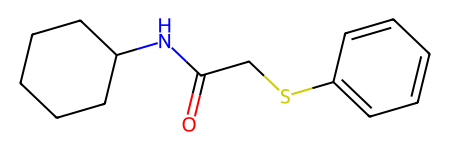

1.0


In [1634]:
import pandas as pd

probs = [tanimoto_similarity(p, deck[200].mol) for p in products]

choices = boltzmann_sampling(probs, 0.0, size=10)
display(products[choices[0]])
print(probs[choices[0]])

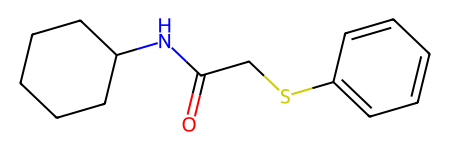

In [1544]:
Chem.MolFromSmiles(_clean(deck[200].mol))